<a href="https://colab.research.google.com/github/ayyucedemirbas/brain_tumor_classification/blob/main/ResNet50_Brain_Tumor_Classification_Grad_cam.ipynb" target="_parent"><img src="https://colab.research.google.com/assets/colab-badge.svg" alt="Open In Colab"/></a>

In [ ]:
!mkdir ~/.kaggle
!touch ~/.kaggle/kaggle.json

In [4]:
api_token = {"username":"username","key":"key"}

import json

with open('/root/.kaggle/kaggle.json', 'w') as file:
    json.dump(api_token, file)

In [5]:
!kaggle datasets download -d masoudnickparvar/brain-tumor-mri-dataset

100% 148M/149M [00:08<00:00, 24.1MB/s]
100% 149M/149M [00:08<00:00, 19.3MB/s]


In [6]:
!unzip -qq brain-tumor-mri-dataset.zip 

In [16]:
import tensorflow as tf
from tensorflow import keras
from tensorflow.keras import layers
from tensorflow.keras.models import Sequential, load_model
from tensorflow.keras.layers import Dense, Flatten, Conv2D, MaxPooling2D, Dropout, GlobalAveragePooling2D
from tensorflow.keras.models import Model
from tensorflow.keras.callbacks import ModelCheckpoint, EarlyStopping
from tensorflow.keras.optimizers import Adam
from tensorflow.keras import regularizers
import matplotlib.pyplot as plt
import matplotlib.image as mpimg
from keras.preprocessing import image
import numpy as np
import os
import datetime
%matplotlib inline
     

In [8]:
tf.keras.utils.set_random_seed(1234)

In [9]:
imagePaths = "Training"
test_path="Testing"

In [10]:
!ls -al Testing

total 64
drwxr-xr-x 6 root root  4096 Feb  2 17:42 .
drwxr-xr-x 1 root root  4096 Feb  2 17:42 ..
drwxr-xr-x 2 root root 12288 Feb  2 17:42 glioma
drwxr-xr-x 2 root root 12288 Feb  2 17:42 meningioma
drwxr-xr-x 2 root root 20480 Feb  2 17:42 notumor
drwxr-xr-x 2 root root 12288 Feb  2 17:42 pituitary


In [11]:
batch_size=16
img_height = 224
img_width = 224

In [12]:
train_ds = tf.keras.preprocessing.image_dataset_from_directory(
  imagePaths,
  #color_mode='grayscale',
  validation_split=0.15,
  subset="training",
  seed=123,
  image_size=(img_height, img_width),
  batch_size=batch_size)

Found 5712 files belonging to 4 classes.
Using 4856 files for training.


In [13]:
val_ds = tf.keras.preprocessing.image_dataset_from_directory(
  imagePaths, 
  #color_mode='grayscale',
  validation_split=0.15,
  subset="validation",
  seed=123,
  image_size=(img_height, img_width),
  batch_size=batch_size)

Found 5712 files belonging to 4 classes.
Using 856 files for validation.


In [14]:
test_ds = tf.keras.preprocessing.image_dataset_from_directory(
  test_path,
  #seed=123,
  image_size=(img_height, img_width),
  #label_mode="categorical",
  batch_size=batch_size)

Found 1311 files belonging to 4 classes.


In [15]:
for image_batch, labels_batch in train_ds:
  print(image_batch.shape)
  print(labels_batch.shape)
  break

(16, 224, 224, 3)
(16,)


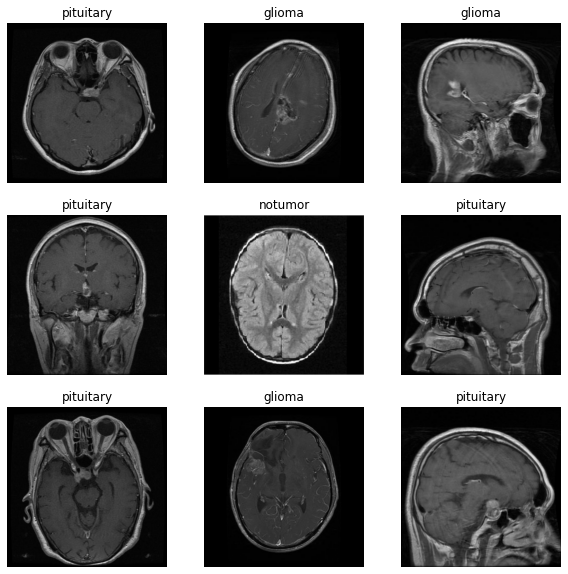

In [ ]:
class_names = train_ds.class_names
plt.figure(figsize=(10, 10))
for images, labels in train_ds.take(1):
  for i in range(9):
    ax = plt.subplot(3, 3, i + 1)
    plt.imshow(images[i].numpy().astype("uint8"))
    plt.title(class_names[labels[i]])
    plt.axis("off")

In [ ]:
data_augmentation= Sequential([
                               layers.RandomFlip("horizontal"),
                               layers.RandomBrightness(factor=0.1, value_range=(0, 255), seed=123)
])

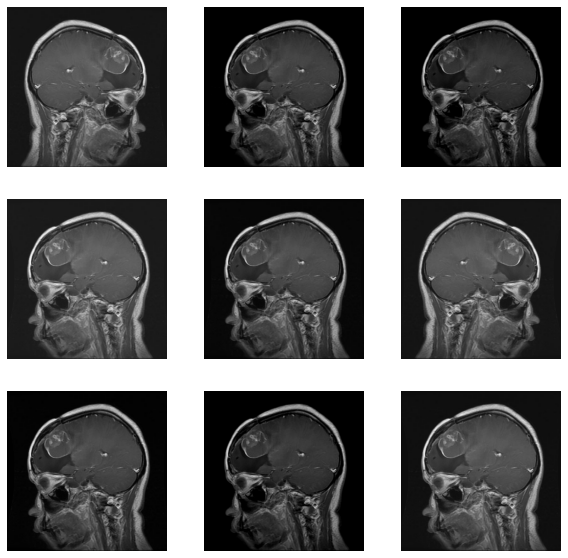

In [ ]:
plt.figure(figsize=(10, 10))
for images, _ in train_ds.take(1):
    for i in range(9):
        augmented_images = data_augmentation(images)
        ax = plt.subplot(3, 3, i + 1)
        plt.imshow(augmented_images[0].numpy().astype("uint8"))
        plt.axis("off")

In [17]:
resnet_base= tf.keras.applications.ResNet50(
    include_top=False,
    weights="imagenet",
    input_shape=(224, 224, 3),
)

94765736/94765736 [==============================] - 5s 0us/step


In [18]:
x = resnet_base.output
x = GlobalAveragePooling2D()(x)
x = Dropout(0.5)(x)
x = Dense(4, activation='softmax')(x)
model = Model(inputs=resnet_base.input, 
              outputs=x)

In [19]:
model.summary()

Model: "model"
__________________________________________________________________________________________________
 Layer (type)                   Output Shape         Param #     Connected to                     
 input_1 (InputLayer)           [(None, 224, 224, 3  0           []                               
                                )]                                                                
                                                                                                  
 conv1_pad (ZeroPadding2D)      (None, 230, 230, 3)  0           ['input_1[0][0]']                
                                                                                                  
 conv1_conv (Conv2D)            (None, 112, 112, 64  9472        ['conv1_pad[0][0]']              
                                )                                                                 
                                                                                              

In [20]:
from keras.utils.vis_utils import plot_model

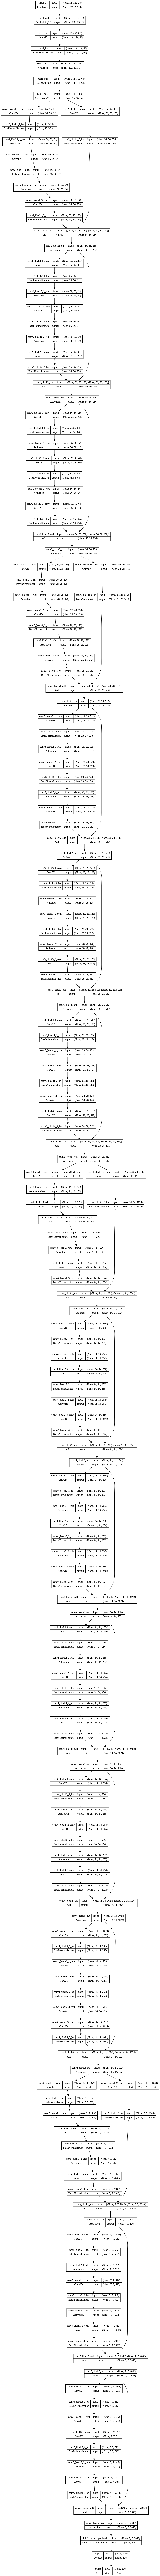

In [21]:
plot_model(model, to_file='model_plot.png', show_shapes=True, show_layer_names=True)

In [22]:
def get_early_stopping():
    
    return tf.keras.callbacks.EarlyStopping(monitor='val_loss', patience=5)

In [23]:
def get_checkpoint_best_only():
    
    checkpoint_best_path= 'checkpoints_best_only'
    checkpoint_best= ModelCheckpoint(filepath=checkpoint_best_path,
                           frequency='epoch',
                           save_weights_only=False,
                           monitor='val_accuracy',
                           save_best_only=True,
                           verbose=1)
    return checkpoint_best

In [24]:
checkpoint_best_only = get_checkpoint_best_only()
early_stopping = get_early_stopping()
log_dir = "logs/fit/" + datetime.datetime.now().strftime("%Y%m%d-%H%M%S")
tensorboard_callback = tf.keras.callbacks.TensorBoard(log_dir=log_dir, histogram_freq=1)

#callbacks = [checkpoint_best_only, early_stopping, tensorboard_callback]
callbacks = [checkpoint_best_only, tensorboard_callback, early_stopping]

In [25]:
import numpy as np
from sklearn.utils.class_weight import compute_class_weight
from sklearn.preprocessing import MultiLabelBinarizer


def generate_class_weights(class_series, multi_class=True, one_hot_encoded=False):
  """
  Method to generate class weights given a set of multi-class or multi-label labels, both one-hot-encoded or not.
  Some examples of different formats of class_series and their outputs are:
    - generate_class_weights(['mango', 'lemon', 'banana', 'mango'], multi_class=True, one_hot_encoded=False)
    {'banana': 1.3333333333333333, 'lemon': 1.3333333333333333, 'mango': 0.6666666666666666}
    - generate_class_weights([[1, 0, 0], [0, 1, 0], [0, 0, 1], [1, 0, 0]], multi_class=True, one_hot_encoded=True)
    {0: 0.6666666666666666, 1: 1.3333333333333333, 2: 1.3333333333333333}
    - generate_class_weights([['mango', 'lemon'], ['mango'], ['lemon', 'banana'], ['lemon']], multi_class=False, one_hot_encoded=False)
    {'banana': 1.3333333333333333, 'lemon': 0.4444444444444444, 'mango': 0.6666666666666666}
    - generate_class_weights([[0, 1, 1], [0, 0, 1], [1, 1, 0], [0, 1, 0]], multi_class=False, one_hot_encoded=True)
    {0: 1.3333333333333333, 1: 0.4444444444444444, 2: 0.6666666666666666}
  The output is a dictionary in the format { class_label: class_weight }. In case the input is one hot encoded, the class_label would be index
  of appareance of the label when the dataset was processed. 
  In multi_class this is np.unique(class_series) and in multi-label np.unique(np.concatenate(class_series)).
  Author: Angel Igareta (angel@igareta.com)
  """
  if multi_class:
    # If class is one hot encoded, transform to categorical labels to use compute_class_weight   
    if one_hot_encoded:
      class_series = np.argmax(class_series, axis=1)
  
    # Compute class weights with sklearn method
    class_labels = np.unique(class_series)
    class_weights = compute_class_weight(class_weight='balanced', classes=class_labels, y=class_series)
    return dict(zip(class_labels, class_weights))
  else:
    # It is neccessary that the multi-label values are one-hot encoded
    mlb = None
    if not one_hot_encoded:
      mlb = MultiLabelBinarizer()
      class_series = mlb.fit_transform(class_series)

    n_samples = len(class_series)
    n_classes = len(class_series[0])

    # Count each class frequency
    class_count = [0] * n_classes
    for classes in class_series:
        for index in range(n_classes):
            if classes[index] != 0:
                class_count[index] += 1
    
    # Compute class weights using balanced method
    class_weights = [n_samples / (n_classes * freq) if freq > 0 else 1 for freq in class_count]
    class_labels = range(len(class_weights)) if mlb is None else mlb.classes_
    return dict(zip(class_labels, class_weights))

In [26]:
y_train= tf.concat([y for x, y in train_ds], axis=0)

In [27]:
class_weights = generate_class_weights(y_train.numpy())

In [28]:
class_weights

{0: 1.0639789658194567,
 1: 1.0848972296693475,
 2: 0.8992592592592593,
 3: 0.9743178170144462}

In [29]:
model.compile(
  optimizer='adam',
  loss=tf.losses.SparseCategoricalCrossentropy(),
  metrics=['accuracy'])

In [30]:
history = model.fit(train_ds, validation_data=val_ds, batch_size=batch_size, epochs=50, class_weight=class_weights, callbacks=callbacks)

Epoch 1/50
304/304 [==============================] - ETA: 0s - loss: 0.6054 - accuracy: 0.8085
Epoch 1: val_accuracy improved from -inf to 0.66238, saving model to checkpoints_best_only


304/304 [==============================] - 98s 274ms/step - loss: 0.6054 - accuracy: 0.8085 - val_loss: 1.8783 - val_accuracy: 0.6624
Epoch 2/50
304/304 [==============================] - ETA: 0s - loss: 0.3207 - accuracy: 0.8898
Epoch 2: val_accuracy did not improve from 0.66238
304/304 [==============================] - 63s 207ms/step - loss: 0.3207 - accuracy: 0.8898 - val_loss: 1.7917 - val_accuracy: 0.6063
Epoch 3/50
304/304 [==============================] - ETA: 0s - loss: 0.1912 - accuracy: 0.9362
Epoch 3: val_accuracy improved from 0.66238 to 0.86565, saving model to checkpoints_best_only


304/304 [==============================] - 81s 266ms/step - loss: 0.1912 - accuracy: 0.9362 - val_loss: 0.4331 - val_accuracy: 0.8657
Epoch 4/50
304/304 [==============================] - ETA: 0s - loss: 0.1480 - accuracy: 0.9504
Epoch 4: val_accuracy did not improve from 0.86565
304/304 [==============================] - 63s 206ms/step - loss: 0.1480 - accuracy: 0.9504 - val_loss: 0.5616 - val_accuracy: 0.7967
Epoch 5/50
304/304 [==============================] - ETA: 0s - loss: 0.1370 - accuracy: 0.9545
Epoch 5: val_accuracy improved from 0.86565 to 0.93224, saving model to checkpoints_best_only


304/304 [==============================] - 83s 271ms/step - loss: 0.1370 - accuracy: 0.9545 - val_loss: 0.2146 - val_accuracy: 0.9322
Epoch 6/50
304/304 [==============================] - ETA: 0s - loss: 0.1088 - accuracy: 0.9638
Epoch 6: val_accuracy did not improve from 0.93224
304/304 [==============================] - 63s 206ms/step - loss: 0.1088 - accuracy: 0.9638 - val_loss: 0.9603 - val_accuracy: 0.8049
Epoch 7/50
304/304 [==============================] - ETA: 0s - loss: 0.1251 - accuracy: 0.9596
Epoch 7: val_accuracy improved from 0.93224 to 0.93808, saving model to checkpoints_best_only


304/304 [==============================] - 81s 265ms/step - loss: 0.1251 - accuracy: 0.9596 - val_loss: 0.1928 - val_accuracy: 0.9381
Epoch 8/50
304/304 [==============================] - ETA: 0s - loss: 0.0773 - accuracy: 0.9773
Epoch 8: val_accuracy improved from 0.93808 to 0.94159, saving model to checkpoints_best_only


304/304 [==============================] - 80s 264ms/step - loss: 0.0773 - accuracy: 0.9773 - val_loss: 0.1864 - val_accuracy: 0.9416
Epoch 9/50
304/304 [==============================] - ETA: 0s - loss: 0.0469 - accuracy: 0.9881
Epoch 9: val_accuracy did not improve from 0.94159
304/304 [==============================] - 63s 207ms/step - loss: 0.0469 - accuracy: 0.9881 - val_loss: 0.2489 - val_accuracy: 0.9241
Epoch 10/50
304/304 [==============================] - ETA: 0s - loss: 0.1050 - accuracy: 0.9660
Epoch 10: val_accuracy did not improve from 0.94159
304/304 [==============================] - 63s 206ms/step - loss: 0.1050 - accuracy: 0.9660 - val_loss: 2.9016 - val_accuracy: 0.5923
Epoch 11/50
304/304 [==============================] - ETA: 0s - loss: 0.0523 - accuracy: 0.9829
Epoch 11: val_accuracy improved from 0.94159 to 0.96495, saving model to checkpoints_best_only


304/304 [==============================] - 80s 263ms/step - loss: 0.0523 - accuracy: 0.9829 - val_loss: 0.1147 - val_accuracy: 0.9650
Epoch 12/50
304/304 [==============================] - ETA: 0s - loss: 0.0491 - accuracy: 0.9868
Epoch 12: val_accuracy did not improve from 0.96495
304/304 [==============================] - 63s 206ms/step - loss: 0.0491 - accuracy: 0.9868 - val_loss: 0.2839 - val_accuracy: 0.9299
Epoch 13/50
304/304 [==============================] - ETA: 0s - loss: 0.0666 - accuracy: 0.9759
Epoch 13: val_accuracy did not improve from 0.96495
304/304 [==============================] - 62s 205ms/step - loss: 0.0666 - accuracy: 0.9759 - val_loss: 1.6317 - val_accuracy: 0.6414
Epoch 14/50
304/304 [==============================] - ETA: 0s - loss: 0.0482 - accuracy: 0.9833
Epoch 14: val_accuracy did not improve from 0.96495
304/304 [==============================] - 65s 213ms/step - loss: 0.0482 - accuracy: 0.9833 - val_loss: 0.2809 - val_accuracy: 0.9089
Epoch 15/50
304/3

In [31]:
model.load_weights("checkpoints_best_only")

In [32]:
model.evaluate(test_ds)

82/82 [==============================] - 5s 61ms/step - loss: 0.1157 - accuracy: 0.9611


[0.11567136645317078, 0.9610983729362488]

In [ ]:
import matplotlib.pyplot as plt

In [33]:
from sklearn.metrics import classification_report, confusion_matrix

In [34]:
predictions = np.array([])
labels =  np.array([])
for x, y in test_ds:
  Y_pred=model.predict(x)
  y_prediction = np.argmax(Y_pred, axis=1)
  predictions = np.concatenate([predictions, y_prediction])
  labels = np.concatenate([labels, y.numpy()])

1/1 [==============================] - 0s 40ms/step


In [35]:
print('Confusion Matrix')
print(confusion_matrix(y_true=labels, y_pred=predictions))

Confusion Matrix
[[273  23   0   4]
 [  4 293   4   5]
 [  0   7 398   0]
 [  1   3   0 296]]


In [36]:
classes=['glioma','meningioma', 'notumor','pituitary']

[[273  23   0   4]
 [  4 293   4   5]
 [  0   7 398   0]
 [  1   3   0 296]]


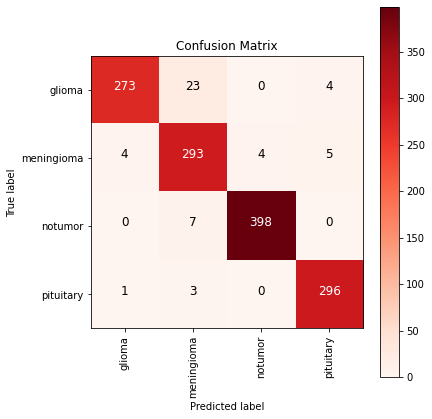

In [37]:
import itertools
def plot_confusion_matrix(cm, classes,
                          normalize = False,
                          title = 'Confusion Matrix',
                          cmap = plt.cm.Reds):
    
    plt.figure(figsize = (6,6))
    plt.imshow(cm, interpolation = 'nearest', cmap = cmap)
    plt.title(title)
    plt.colorbar()
    plt.grid(False)
    tick_marks = np.arange(len(classes))
    plt.xticks(tick_marks, classes, rotation = 90)
    plt.yticks(tick_marks, classes)
    if normalize:
        cm = cm.astype('float') / cm.sum(axis = 1)[:, np.newaxis]

    thresh = cm.max() / 2.
    cm = np.round(cm,2)
    for i, j in itertools.product(range(cm.shape[0]), range(cm.shape[1])):
        plt.text(j, i, cm[i, j],
                 fontsize = 12,
                 horizontalalignment = "center",
                 color = "white" if cm[i, j] > thresh else "black")
    plt.tight_layout()
    plt.ylabel('True label')
    plt.xlabel('Predicted label')
    plt.show()
#get confusion matrix
cm = confusion_matrix(labels, predictions)
print(cm)

#plot
plot_confusion_matrix(cm, classes, normalize=False)

In [38]:
print('Classification Report')
target_names = classes
print(classification_report(y_true=labels, y_pred=predictions, target_names=target_names))

Classification Report
              precision    recall  f1-score   support

      glioma       0.98      0.91      0.94       300
  meningioma       0.90      0.96      0.93       306
     notumor       0.99      0.98      0.99       405
   pituitary       0.97      0.99      0.98       300

    accuracy                           0.96      1311
   macro avg       0.96      0.96      0.96      1311
weighted avg       0.96      0.96      0.96      1311



In [39]:
model.save("brain_model.h5")

In [40]:
for i in model.layers:
  print(i.name)

input_1
conv1_pad
conv1_conv
conv1_bn
conv1_relu
pool1_pad
pool1_pool
conv2_block1_1_conv
conv2_block1_1_bn
conv2_block1_1_relu
conv2_block1_2_conv
conv2_block1_2_bn
conv2_block1_2_relu
conv2_block1_0_conv
conv2_block1_3_conv
conv2_block1_0_bn
conv2_block1_3_bn
conv2_block1_add
conv2_block1_out
conv2_block2_1_conv
conv2_block2_1_bn
conv2_block2_1_relu
conv2_block2_2_conv
conv2_block2_2_bn
conv2_block2_2_relu
conv2_block2_3_conv
conv2_block2_3_bn
conv2_block2_add
conv2_block2_out
conv2_block3_1_conv
conv2_block3_1_bn
conv2_block3_1_relu
conv2_block3_2_conv
conv2_block3_2_bn
conv2_block3_2_relu
conv2_block3_3_conv
conv2_block3_3_bn
conv2_block3_add
conv2_block3_out
conv3_block1_1_conv
conv3_block1_1_bn
conv3_block1_1_relu
conv3_block1_2_conv
conv3_block1_2_bn
conv3_block1_2_relu
conv3_block1_0_conv
conv3_block1_3_conv
conv3_block1_0_bn
conv3_block1_3_bn
conv3_block1_add
conv3_block1_out
conv3_block2_1_conv
conv3_block2_1_bn
conv3_block2_1_relu
conv3_block2_2_conv
conv3_block2_2_bn
conv3_

In [41]:
from IPython.display import Image, display
     

def get_img_array(img_path, size):
    # `img` is a PIL image of size 299x299
    img = keras.preprocessing.image.load_img(img_path, target_size=size)
    # `array` is a float32 Numpy array of shape (299, 299, 3)
    array = keras.preprocessing.image.img_to_array(img)
    # We add a dimension to transform our array into a "batch"
    # of size (1, 299, 299, 3)
    array = np.expand_dims(array, axis=0)
    return array


def make_gradcam_heatmap(img_array, model, last_conv_layer_name, pred_index=None):
    # First, we create a model that maps the input image to the activations
    # of the last conv layer as well as the output predictions
    grad_model = tf.keras.models.Model(
        [model.inputs], [model.get_layer(last_conv_layer_name).output, model.output]
    )

    # Then, we compute the gradient of the top predicted class for our input image
    # with respect to the activations of the last conv layer
    with tf.GradientTape() as tape:
        last_conv_layer_output, preds = grad_model(img_array)
        if pred_index is None:
            pred_index = tf.argmax(preds[0])
        class_channel = preds[:, pred_index]

    # This is the gradient of the output neuron (top predicted or chosen)
    # with regard to the output feature map of the last conv layer
    grads = tape.gradient(class_channel, last_conv_layer_output)

    # This is a vector where each entry is the mean intensity of the gradient
    # over a specific feature map channel
    pooled_grads = tf.reduce_mean(grads, axis=(0, 1, 2))

    # We multiply each channel in the feature map array
    # by "how important this channel is" with regard to the top predicted class
    # then sum all the channels to obtain the heatmap class activation
    last_conv_layer_output = last_conv_layer_output[0]
    heatmap = last_conv_layer_output @ pooled_grads[..., tf.newaxis]
    heatmap = tf.squeeze(heatmap)

    # For visualization purpose, we will also normalize the heatmap between 0 & 1
    heatmap = tf.maximum(heatmap, 0) / tf.math.reduce_max(heatmap)
    return heatmap.numpy()

In [42]:
img_path = tf.keras.utils.get_file(
    "tumor.jpg", 
    "https://scx2.b-cdn.net/gfx/news/hires/2009/acrystalball.jpg"
)
    

20915/20915 [==============================] - 0s 0us/step


In [43]:
def get_img_array(img_path, target_size):
  img = keras.utils.load_img(img_path, target_size=target_size)
  array = keras.utils.img_to_array(img)
  array = np.expand_dims(array, axis=0)
  return array

In [44]:
img_array = get_img_array(img_path, target_size=(224, 224))

In [45]:
last_conv_layer_name = "conv5_block3_out"
# Remove last layer's softmax
model.layers[-1].activation = None

1/1 [==============================] - 0s 405ms/step
Predicted: [7.9226331e-05 4.6843728e-03 9.9413043e-01 1.1058963e-03]


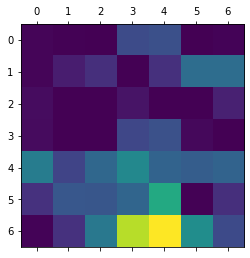

In [46]:
# Print what the top predicted class is
preds = model.predict(img_array)
print("Predicted:", preds[0])

# Generate class activation heatmap
heatmap = make_gradcam_heatmap(img_array, model, last_conv_layer_name)

# Display heatmap
plt.matshow(heatmap)
plt.show()

In [47]:
import matplotlib.cm as matcm

In [48]:
from IPython.display import Image, display
     

def save_and_display_gradcam(img_path, heatmap, cam_path="cam.jpg", alpha=0.4):
    # Load the original image
    img = keras.preprocessing.image.load_img(img_path)
    img = keras.preprocessing.image.img_to_array(img)

    # Rescale heatmap to a range 0-255
    heatmap = np.uint8(255 * heatmap)

    # Use jet colormap to colorize heatmap
    jet = matcm.get_cmap("jet")

    # Use RGB values of the colormap
    jet_colors = jet(np.arange(256))[:, :3]
    jet_heatmap = jet_colors[heatmap]

    # Create an image with RGB colorized heatmap
    jet_heatmap = keras.preprocessing.image.array_to_img(jet_heatmap)
    jet_heatmap = jet_heatmap.resize((img.shape[1], img.shape[0]))
    jet_heatmap = keras.preprocessing.image.img_to_array(jet_heatmap)

    # Superimpose the heatmap on original image
    superimposed_img = jet_heatmap * alpha + img
    superimposed_img = keras.preprocessing.image.array_to_img(superimposed_img)

    # Save the superimposed image
    superimposed_img.save(cam_path)

    # Display Grad CAM
    display(Image(cam_path))
     

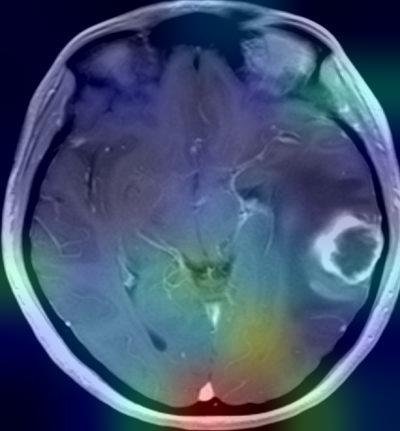

In [49]:
save_and_display_gradcam(img_path, heatmap)

In [50]:
img_path1 = tf.keras.utils.get_file(
    "tumor1.jpg", 
    "https://raw.githubusercontent.com/ayyucedemirbas/dummy_ds_to_delete/main/2.jpeg"
)

16371/16371 [==============================] - 0s 0us/step


In [51]:
img_array1 = get_img_array(img_path1, target_size=(224, 224))

1/1 [==============================] - 0s 21ms/step
Predicted: [2.3984739e-14 1.0000000e+00 1.2725711e-15 3.6927492e-12]


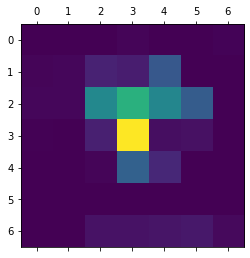

In [52]:
# Print what the top predicted class is
preds = model.predict(img_array1)
print("Predicted:", preds[0])

# Generate class activation heatmap
heatmap = make_gradcam_heatmap(img_array1, model, last_conv_layer_name)

# Display heatmap
plt.matshow(heatmap)
plt.show()

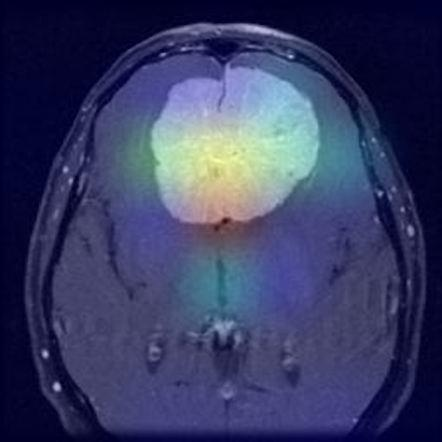

In [53]:
save_and_display_gradcam(img_path1, heatmap)

In [54]:
img_path2 = tf.keras.utils.get_file(
    "tumor3.jpg", 
    "https://raw.githubusercontent.com/ayyucedemirbas/dummy_ds_to_delete/main/4.jpeg"
)

5826/5826 [==============================] - 0s 0us/step


In [55]:
img_array2 = get_img_array(img_path2, target_size=(224, 224))

1/1 [==============================] - 0s 21ms/step
Predicted: [8.937712e-10 1.000000e+00 4.096010e-11 1.577054e-08]


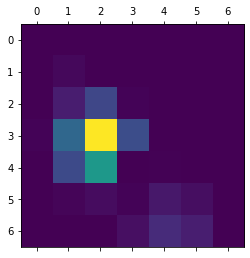

In [56]:
# Print what the top predicted class is
preds = model.predict(img_array2)
print("Predicted:", preds[0])

# Generate class activation heatmap
heatmap = make_gradcam_heatmap(img_array2, model, last_conv_layer_name)

# Display heatmap
plt.matshow(heatmap)
plt.show()

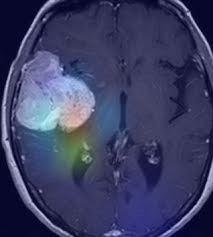

In [57]:
save_and_display_gradcam(img_path2, heatmap)

In [58]:
img_path4 = tf.keras.utils.get_file(
    "glioma.jpg", 
    "https://raw.githubusercontent.com/ayyucedemirbas/dummy_ds_to_delete/main/7.jpg"
)

106377/106377 [==============================] - 0s 0us/step


In [61]:
img_array4 = get_img_array(img_path4, target_size=(224, 224))

1/1 [==============================] - 0s 102ms/step
Predicted: [4.1041179e-10 9.9809164e-01 1.9083295e-03 1.3974896e-08]


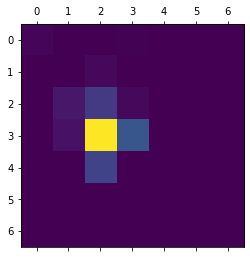

In [62]:
# Print what the top predicted class is
preds = model.predict(img_array4)
print("Predicted:", preds[0])

# Generate class activation heatmap
heatmap = make_gradcam_heatmap(img_array4, model, last_conv_layer_name)

# Display heatmap
plt.matshow(heatmap)
plt.show()

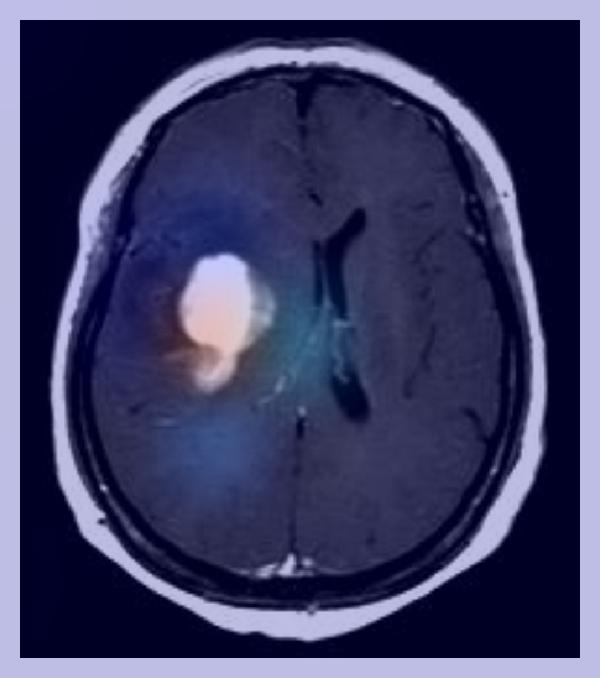

In [63]:
save_and_display_gradcam(img_path4, heatmap)

In [64]:
img_path4 = tf.keras.utils.get_file(
    "tum.png", 
    "https://raw.githubusercontent.com/ayyucedemirbas/dummy_ds_to_delete/main/8.png"
)

297498/297498 [==============================] - 0s 0us/step


In [65]:
img_array4 = get_img_array(img_path4, target_size=(224, 224))

1/1 [==============================] - 0s 43ms/step
Predicted: [3.6172427e-05 2.1824909e-03 1.0421391e-02 9.8735994e-01]


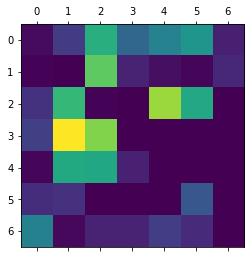

In [66]:
# Print what the top predicted class is
preds = model.predict(img_array4)
print("Predicted:", preds[0])

# Generate class activation heatmap
heatmap = make_gradcam_heatmap(img_array4, model, last_conv_layer_name)

# Display heatmap
plt.matshow(heatmap)
plt.show()

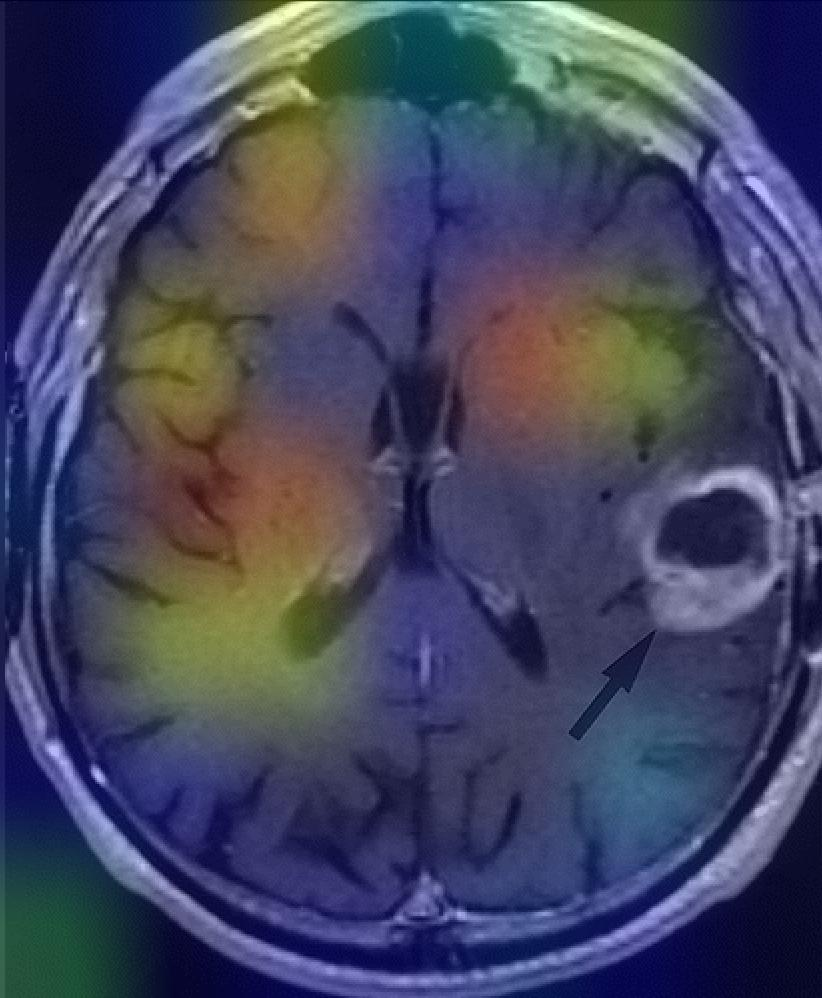

In [67]:
save_and_display_gradcam(img_path4, heatmap)

In [68]:
import cv2

In [85]:
from numpy import asarray

In [100]:
test_img = cv2.imread("/content/Testing/meningioma/Te-meTr_0003.jpg")
dim = (224, 224)
  
# resize image
test_img = cv2.resize(test_img, dim)

test_img = asarray(test_img)
test_img=np.reshape(test_img, (-1, 224, 224, 3)) 

In [101]:
test_img.shape

(1, 224, 224, 3)

1/1 [==============================] - 1s 759ms/step
Predicted: [-4.1251116  7.4151483 -6.0025935 -5.719777 ]


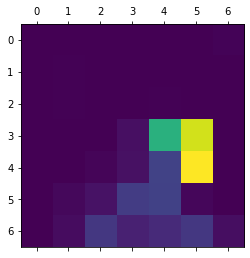

In [102]:
# Print what the top predicted class is
preds = model.predict(test_img)
print("Predicted:", preds[0])

# Generate class activation heatmap
heatmap = make_gradcam_heatmap(test_img, model, last_conv_layer_name)

# Display heatmap
plt.matshow(heatmap)
plt.show()

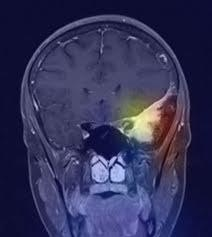

In [107]:
save_and_display_gradcam("/content/Testing/meningioma/Te-meTr_0003.jpg", heatmap)

In [108]:
test_img = cv2.imread("/content/Testing/meningioma/Te-meTr_0007.jpg")
dim = (224, 224)
  
# resize image
test_img = cv2.resize(test_img, dim)

test_img = asarray(test_img)
test_img=np.reshape(test_img, (-1, 224, 224, 3)) 

1/1 [==============================] - 0s 61ms/step
Predicted: [-5.2784667   2.3493547  -3.2163143  -0.27900562]


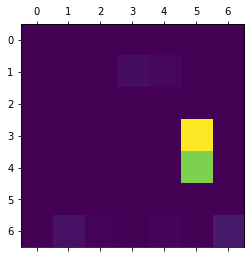

In [109]:
# Print what the top predicted class is
preds = model.predict(test_img)
print("Predicted:", preds[0])

# Generate class activation heatmap
heatmap = make_gradcam_heatmap(test_img, model, last_conv_layer_name)

# Display heatmap
plt.matshow(heatmap)
plt.show()

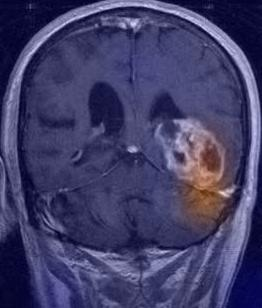

In [110]:
save_and_display_gradcam("/content/Testing/meningioma/Te-meTr_0007.jpg", heatmap)

1/1 [==============================] - 0s 21ms/step
Predicted: [ -2.5576196  11.222217  -13.179659   -5.3366327]


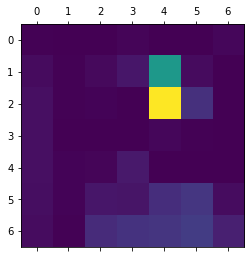

In [111]:
test_img = cv2.imread("/content/Testing/meningioma/Te-me_0211.jpg")
dim = (224, 224)
  
# resize image
test_img = cv2.resize(test_img, dim)

test_img = asarray(test_img)
test_img=np.reshape(test_img, (-1, 224, 224, 3)) 
# Print what the top predicted class is
preds = model.predict(test_img)
print("Predicted:", preds[0])

# Generate class activation heatmap
heatmap = make_gradcam_heatmap(test_img, model, last_conv_layer_name)

# Display heatmap
plt.matshow(heatmap)
plt.show()

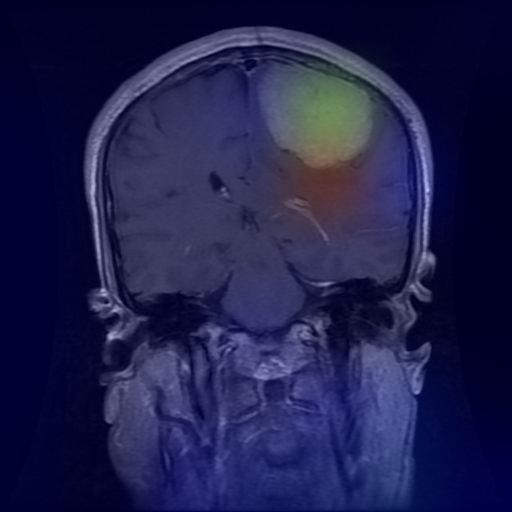

In [113]:
save_and_display_gradcam("/content/Testing/meningioma/Te-me_0211.jpg", heatmap)

1/1 [==============================] - 0s 26ms/step
Predicted: [-8.09699     6.94092     0.99373204 -7.200968  ]


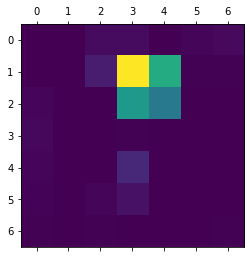

In [114]:
test_img = cv2.imread("/content/Testing/meningioma/Te-me_0113.jpg")
dim = (224, 224)
  
# resize image
test_img = cv2.resize(test_img, dim)

test_img = asarray(test_img)
test_img=np.reshape(test_img, (-1, 224, 224, 3)) 
# Print what the top predicted class is
preds = model.predict(test_img)
print("Predicted:", preds[0])

# Generate class activation heatmap
heatmap = make_gradcam_heatmap(test_img, model, last_conv_layer_name)

# Display heatmap
plt.matshow(heatmap)
plt.show()

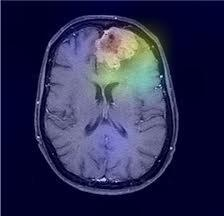

In [115]:
save_and_display_gradcam("/content/Testing/meningioma/Te-me_0113.jpg", heatmap)

1/1 [==============================] - 0s 38ms/step
Predicted: [-11.011033  14.885042  -8.206256  -5.898675]


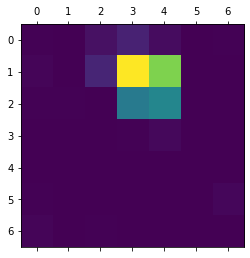

In [116]:
test_img = cv2.imread("/content/Testing/meningioma/Te-me_0077.jpg")
dim = (224, 224)
  
# resize image
test_img = cv2.resize(test_img, dim)

test_img = asarray(test_img)
test_img=np.reshape(test_img, (-1, 224, 224, 3)) 
# Print what the top predicted class is
preds = model.predict(test_img)
print("Predicted:", preds[0])

# Generate class activation heatmap
heatmap = make_gradcam_heatmap(test_img, model, last_conv_layer_name)

# Display heatmap
plt.matshow(heatmap)
plt.show()

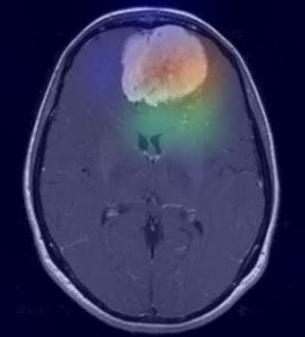

In [117]:
save_and_display_gradcam("/content/Testing/meningioma/Te-me_0077.jpg", heatmap)

1/1 [==============================] - 0s 22ms/step
Predicted: [ -8.893943   15.421847  -11.965435   -6.8514915]


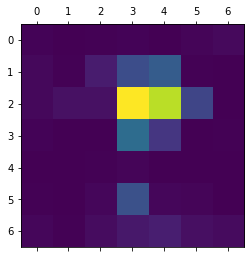

In [118]:
test_img = cv2.imread("/content/Testing/meningioma/Te-me_0028.jpg")
dim = (224, 224)
  
# resize image
test_img = cv2.resize(test_img, dim)

test_img = asarray(test_img)
test_img=np.reshape(test_img, (-1, 224, 224, 3)) 
# Print what the top predicted class is
preds = model.predict(test_img)
print("Predicted:", preds[0])

# Generate class activation heatmap
heatmap = make_gradcam_heatmap(test_img, model, last_conv_layer_name)

# Display heatmap
plt.matshow(heatmap)
plt.show()

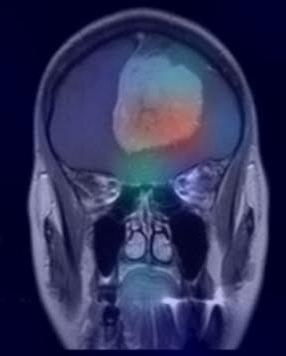

In [119]:
save_and_display_gradcam("/content/Testing/meningioma/Te-me_0028.jpg", heatmap)

1/1 [==============================] - 0s 34ms/step
Predicted: [-9.67124   5.814628  2.65904  -8.150281]


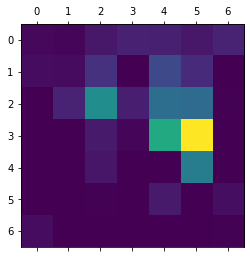

In [120]:
test_img = cv2.imread("/content/Testing/meningioma/Te-meTr_0005.jpg")
dim = (224, 224)
  
# resize image
test_img = cv2.resize(test_img, dim)

test_img = asarray(test_img)
test_img=np.reshape(test_img, (-1, 224, 224, 3)) 
# Print what the top predicted class is
preds = model.predict(test_img)
print("Predicted:", preds[0])

# Generate class activation heatmap
heatmap = make_gradcam_heatmap(test_img, model, last_conv_layer_name)

# Display heatmap
plt.matshow(heatmap)
plt.show()

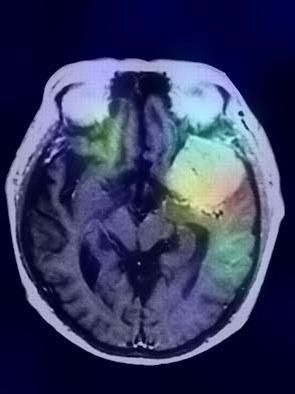

In [121]:
save_and_display_gradcam("/content/Testing/meningioma/Te-meTr_0005.jpg", heatmap)

1/1 [==============================] - 0s 22ms/step
Predicted: [ -1.3326157   9.798041  -11.934116   -6.443449 ]


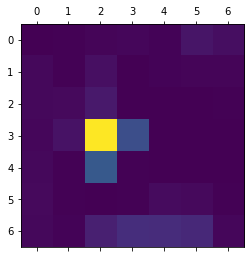

In [122]:
test_img = cv2.imread("/content/Testing/meningioma/Te-me_0152.jpg")
dim = (224, 224)
  
# resize image
test_img = cv2.resize(test_img, dim)

test_img = asarray(test_img)
test_img=np.reshape(test_img, (-1, 224, 224, 3)) 
# Print what the top predicted class is
preds = model.predict(test_img)
print("Predicted:", preds[0])

# Generate class activation heatmap
heatmap = make_gradcam_heatmap(test_img, model, last_conv_layer_name)

# Display heatmap
plt.matshow(heatmap)
plt.show()

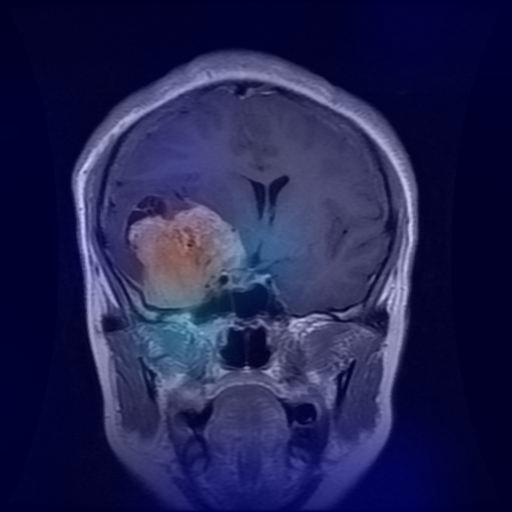

In [123]:
save_and_display_gradcam("/content/Testing/meningioma/Te-me_0152.jpg", heatmap)